# Economic Effects of a Year-Long Lockdown
Nick Brown  
GSE 512

### General setup, importing the libraries we'll need for this 

In [1]:
import numpy as np
from scipy.linalg import null_space # need this for the ergodic distribution
import pandas as pd  #need Pandas for pretty tables
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

### 1. Import the Data

In [2]:
df = pd.read_csv('GDP_cycle.csv')
df = df.rename(columns = {"Unnamed: 0": "Date", "GDP cycle": "GDP_cycle"})
df.head()
Y = df['GDP_cycle']

### 2. Create a Histogram with 5 bins

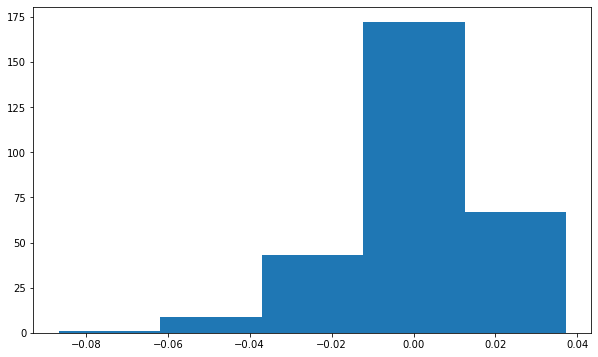

In [3]:
plt.hist(Y, bins = 5)
plt.show()

Now I'm going to get the cutoff zones for each bins. This is so I can create the economic states later on using a loop. 

In [4]:
n, p = np.histogram(Y, bins = 5)
z = p[1:6]
z

array([-0.06186674, -0.03709595, -0.01232517,  0.01244561,  0.0372164 ])

### 3. Classify the States

In [5]:
n=len(z)  # number of groups, 5 in this case with Covid being the lone observation in group 0
states = np.zeros(len(Y))
for i in range(n):
        if i == 0:
            states[np.less_equal(Y,z[i])]=i  #these observations are in the first quartile
        states[np.logical_and(np.greater(Y,z[i-1]),np.less_equal(Y,z[i]))]=i
        #nice use of array-oriented logical functions
states # the states looks good

array([4., 4., 4., 3., 2., 2., 1., 1., 2., 2., 3., 4., 4., 4., 4., 4., 4.,
       3., 3., 4., 4., 4., 4., 3., 2., 2., 2., 2., 3., 4., 4., 4., 3., 3.,
       3., 4., 4., 3., 3., 3., 1., 1., 2., 3., 3., 4., 3., 3., 4., 3., 3.,
       2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2.,
       3., 3., 3., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 4., 4., 3., 4.,
       3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 4., 4., 4.,
       4., 4., 3., 3., 3., 2., 1., 1., 2., 2., 3., 3., 2., 2., 3., 3., 3.,
       3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 4., 3., 3., 3.,
       2., 2., 1., 1., 1., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 3., 4., 4.,
       3., 3., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 2., 2., 2.,
       2., 3., 3., 3., 3.

### 4. Estimate the Markov Matrix and find its Ergodic Distribution

In [6]:
# A function that creates Markov matrices after giving it the states and dimensions of the matrix.
def estimate_markov(x,dim):
    """
    x is the data classified by state
    dim is the dimension of the classification
    
    """
    n=len(x) # number of observations
    m=np.zeros((dim,dim))  # start out with a matrix full of zeros
    for i in range (n-1): #there is no final transition
        m[int(x[i]),int(x[i+1])] +=1 # increment the transition count
    row_sums = sum(m.T)  # get row sums
    m = m/row_sums[:,None]  #divides the rows of matrix m by vector row_sums
    return(m)

In [7]:
dim=len(z)
m_usa=estimate_markov(states,dim)

Here is our Markov matrix, with 5 states. This Markov Matrix is more representative of the US economy as compared to the one with 4 periods, each period with an equal number of observations.

In [8]:
m_usa 

array([[0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.55555556, 0.44444444, 0.        , 0.        ],
       [0.        , 0.06976744, 0.62790698, 0.30232558, 0.        ],
       [0.00584795, 0.00584795, 0.06432749, 0.81871345, 0.10526316],
       [0.        , 0.        , 0.        , 0.28358209, 0.71641791]])

Now it's time to find the Ergodic distribution, and find the long-run probability of being in the "Covid-state" (state 0).

In [9]:
def ergodic(m):
    """
    This code finds the ergodic distribution of a Markov matrix
    It has a couple of important updates.
    np.allclose() is a useful function 
    The calculation of the eigenvalues was subject to rounding error.
    Now I use the left nullspace of m instead
    """
    n=m.shape[0] # number of rows
    T = 1000 # useful constant
    if (m.shape[0] != m.shape[1]): #test for a square matrix
        return('Matrix is not square') 
    if (not np.allclose(m@np.ones(n),np.ones(n))): #test row sums 
        return('This is not a Markov matrix')
    if( not ((m >= 0).all() and (m <= 1).all())): #test probabilities
        return('This is not a Markov matrix')
    m_long = np.linalg.matrix_power(m,T)
    if( not ((m_long > 0).all() and (m_long < 1).all())): #crude test for aperiodic and irreducible
        return('This matrix may not be both aperiodic and irreducible')
    m0=null_space(m.T-np.identity(5)) #need the nullspace of the rows.   That's why I transpose
    return(m0/sum(m0)) # make it into a probability distribution

long_run = ergodic(m_usa)
long_run

array([[0.00347858],
       [0.03130721],
       [0.14957891],
       [0.59483706],
       [0.22079824]])

The long-run probability of being in a covid-state is 0.00348, pretty low all things considered.

### 5. Calculate the Consumption Vector

In [10]:
df['states'] = states
df.head()

,Date,GDP_cycle,states
0,1948-01-01,0.020398,4.0
1,1948-04-01,0.024427,4.0
2,1948-07-01,0.017784,4.0
3,1948-10-01,0.006505,3.0
4,1949-01-01,-0.019847,2.0


In [11]:
# using PANDAS groupby and mean aggregate function to find the means of each state
consumption_vector = np.array(np.exp(df.groupby('states')['GDP_cycle'].mean()))
consumption_vector

array([0.91700943, 0.95784949, 0.97929425, 1.00027525, 1.01999697])

Here is our consumption vector with our consumption in each state. You can see by how much Covid reduced consumption, over 8%.

### Part 6
Here's the asset pricing kernel.  Explain why the diagonal elements are all the same.  Explain also why the matrix is not symmetric.  Explain how the kernel depends upon the Markov matrix.  

In [12]:
K =np.array([[0.99241412, 0.90959066, 0.87019008, 0.83406807, 0.80212633],
       [1.08277913, 0.99241412, 0.94942589, 0.91001476, 0.87516454],
       [1.13180534, 1.03734877, 0.99241412, 0.95121852, 0.91479035],
       [1.18082183, 1.08227451, 1.03539382, 0.99241412, 0.95440831],
       [1.22784372, 1.12537212, 1.07662458, 1.03193337, 0.99241412]])
K

array([[0.99241412, 0.90959066, 0.87019008, 0.83406807, 0.80212633],
       [1.08277913, 0.99241412, 0.94942589, 0.91001476, 0.87516454],
       [1.13180534, 1.03734877, 0.99241412, 0.95121852, 0.91479035],
       [1.18082183, 1.08227451, 1.03539382, 0.99241412, 0.95440831],
       [1.22784372, 1.12537212, 1.07662458, 1.03193337, 0.99241412]])

The diagonal elements are the same because of the way we define K, the asset pricing kernel: 
$$
K =
\left[
\begin{array}{c}
  \dfrac{\nabla U(c)}{\partial U/ \partial c_1 } \\
 \vdots \\
  \dfrac{\nabla U(c)}{\partial U/ \partial c_n } \\
\end{array}
\right]
=
\left[
\begin{array}{ccc}
 \beta \dfrac{u'(c_1)}{u'(c_1)} & \dots & \beta \dfrac{u'(c_n)}{u'(c_1)} \\
 \vdots & \vdots & \vdots \\
 \beta \dfrac{u'(c_1)}{u'(c_n)} & \dots & \beta \dfrac{u'(c_n)}{u'(c_n)} \\
\end{array}
\right]
$$

Each diagonal consists of the marginal felicity of the consumption vector, divided by the same marginal felicity. That equals 1, then multiplied by $\beta$, the discount factor. So in this case, the discount factor appear to be 0.9924. 

The matrix is not symmetric, again because of the way K is defined. If we look at $K[0,1] = 0.909$ versus $K[1,0] = 1.082$ we can see the difference right away. $K[0,1]$ is defined as $\beta \frac{u'(c_1)}{u'(c_0)}$, where $c_0$ is the first entry in the consumption vector, and $c_1$ is the second entry (using Python indexing here, it's easier to be consistent). $K[1,0]$ on the other hand is defined as $\beta \frac{u'(c_0)}{u'(c_1)}$. This will obviously get us different figures because we're switching the order of the division.

The pricing kernel, as show above, depends on the consumption vector consisting of consumption in each state of the economy. In part 5, we created the consumption vector which is the exponentiated means of each "state". These states are what make up the Markov matrix. So the asset pricing kernel $K$ is dependent upon the Markov matrix, and the consumption vector. The size of the asset pricing matrix is also the same as the Markov matrix, so we can conduct matrix multiplication later.

### Part 7
Here is an array of maturities $[1, 2, 4, 8, 20, 40, 80, 120]$ in quarters.  Make a diagram with five yield curves.  Each line in your diagram should consist of a yield curve in a given state.

In [13]:
maturities = np.array([1,2,4,8,20,40,80,120])
maturities

array([  1,   2,   4,   8,  20,  40,  80, 120])

In [14]:
def pricing_T(M,K,R,T):
    """
    M is a markov matrix
    K is a pricing kernel
    R is a matrix of asset payouts.
    T is when these assets mature. They all mature at the same time.
    The asset returns are by column
    """
    if M.shape != K.shape:
        return('Markov matrix and pricing kernels are not conformable.')
    if M.shape[1] != R.shape[0]:
        return('Asset price matrix is not conformable.')
    M1=np.multiply(M,K) #element-by-elemnt multiplication
    P = np.matmul(np.linalg.matrix_power(M1,T), R)  
    #raise M1 to the T the right multiply by R
    return(P)

In [15]:
# R represents bonds, they return a unit of consumption on payout
R = np.array([[1],
             [1],
             [1],
             [1],
             [1]])

pricing_yields = []
for t in maturities:
    P = pricing_T(m_usa,K,R,t)
    yield_p = (1/P)**(1/t)
    pricing_yields.append(yield_p)
    
pricing_yields = np.array(pricing_yields)
pricing_yields

array([[[1.14917421],
        [1.02742375],
        [1.01719609],
        [1.00724655],
        [0.99639199]],

       [[1.08117322],
        [1.02519171],
        [1.01610098],
        [1.00751763],
        [0.99796114]],

       [[1.04716347],
        [1.02166588],
        [1.01443985],
        [1.00751957],
        [1.00033653]],

       [[1.0288033 ],
        [1.01714782],
        [1.01222722],
        [1.00750518],
        [1.00298906]],

       [[1.01635223],
        [1.01192616],
        [1.00969778],
        [1.00756825],
        [1.00560802]],

       [[1.01199387],
        [1.00979148],
        [1.0086742 ],
        [1.00760567],
        [1.00662251]],

       [[1.00981653],
        [1.00871712],
        [1.00815891],
        [1.00762477],
        [1.00713305]],

       [[1.00909179],
        [1.00835924],
        [1.0079872 ],
        [1.00763113],
        [1.0073033 ]]])

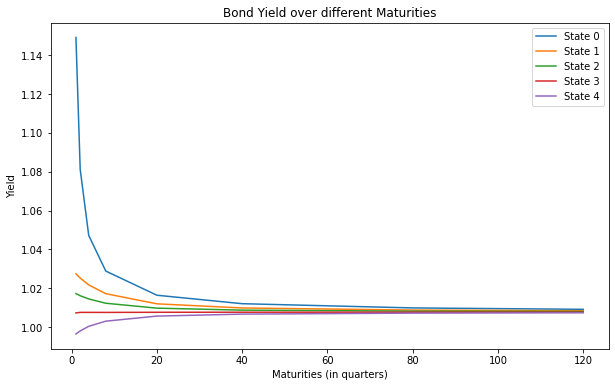

In [16]:
plt.plot(maturities,pricing_yields[:,0], label = 'State 0')
plt.plot(maturities,pricing_yields[:,1], label = 'State 1')
plt.plot(maturities,pricing_yields[:,2], label = 'State 2')
plt.plot(maturities,pricing_yields[:,3], label = 'State 3')
plt.plot(maturities,pricing_yields[:,4], label = 'State 4')
plt.legend()
plt.xlabel('Maturities (in quarters)')
plt.ylabel('Yield')
plt.title('Bond Yield over different Maturities')
plt.show()

We can see that as the maturity rate increases, the bond yields all converge to around 1, regardless of the state we purchased the bond in. This is due to the discount factor from K (which is roughly 0.99), which was given to us in the problem. 

### Part 8
Discuss whether an inverted yield curve conveys information about next period's state. 

As discussed in class, an inverted yield curve has been an indicator for the past seven recessions. So it can convey information about next period's state. At the very least, if you see an inverted yield curve you should be wary of a coming recession.

### Part 9
The stock market is an asset that pays a dividend equal to the economy's consumption in each quarter.  Price the stock market in each state.  (You can truncate the dividends after 10,000 periods.). My vector of prices included the number 137.1 (rounded to 1 decimal) for the best state. 

In [17]:
def pricing_stock(M,K,R,T):
    """
    M is a markov matrix
    K is a pricing kernel
    R is a matrix of asset payouts.  Its columns vary with time
    T is the end of the payout stream
    """
    n=M.shape[0] #number of states
    if M.shape != K.shape:
        return('Markov matrix and pricing kernels are not conformable.')
    if M.shape[1] != R.shape[0]:
        return('Asset price matrix is not conformable.')
    M1=np.multiply(M,K) #element-by-element multiplication
    p=np.zeros(n)
    for t in range(T):
        p += np.matmul(np.linalg.matrix_power(M1,t), R[:,t])  
    #raise M1 to the T the right multiply by t-th column of R
    # Then add them all up
    return(p)

In [18]:
T = 10000
r = ([[consumption_vector[0]],
     [consumption_vector[1]],
     [consumption_vector[2]],
     [consumption_vector[3]],
     [consumption_vector[4]]])
R = r@np.ones((1,T))

prices = pricing_stock(m_usa,K,R,T)
np.round(prices,1)

array([111. , 121.2, 126.5, 131.9, 137.1])

### Part 10
The first row of the Markov matrix was (0, 0, 1, 0, 0).  What is the expected duration of a lockdown  for this matrix?  Change the first row of the matrix so that it is (p, 0,  1-p, 0, 0) for 0 < p < 1 to simulate a four-period lockdown.   What is the correct value of p?   I found a long-run probability of being in a Covid state to be 0.01377061 in this case. 

The expected duration of lockdown for the initial Markov matrix was 1 period (so 1 quarter). 

In [19]:
p = 0.75
new_markov = np.array([[p, 0., 1.-p, 0., 0.],
       [0., 0.55555556, 0.44444444, 0., 0.],
       [0., 0.06976744, 0.62790698, 0.30232558, 0.],
       [0.00584795, 0.00584795, 0.06432749, 0.81871345, 0.10526316],
       [0., 0., 0., 0.28358209, 0.71641791]])

In [20]:
new_long_run = ergodic(new_markov)
#new_long_run = new_long_run.real.astype(float)
new_long_run

array([[0.0137706 ],
       [0.03098387],
       [0.14803406],
       [0.58869361],
       [0.21851785]])

The correct value of p is 0.75, this can be found using the formula: $E(X) = \dfrac{1}{1-\pi_{ii}}$. This gives us the expect amount of periods we would remain in the Covid state. So when $\pi_{11}$ is equal to 0.75, the expected amount of periods we would remain in the Covid state is 4.

### Part 11
Simulate and graph the time series of consumption and the stock market for 400 periods  in the two different scenarios, the one-period lockdown and the four-period lockdown.   You should multiply consumption times 100 to put it on the same scale as the stock market.

I'll start by getting the long-run stock prices after 400 periods, for both a 1 period lockdown scenario and a 4 period lockdown scenario.

In [21]:
# 1 period-lockdown stock prices (after 400 periods)
T = 400
r = ([[consumption_vector[0]],
     [consumption_vector[1]],
     [consumption_vector[2]],
     [consumption_vector[3]],
     [consumption_vector[4]]])
R = r@np.ones((1,T))

prices = pricing_stock(m_usa,K,R,T)
np.round(prices,1)

array([105.8, 115.4, 120.5, 125.7, 130.6])

In [22]:
# 4 period-lockdown stock prices (after 400 periods)
T = 400
r = ([[consumption_vector[0]],
     [consumption_vector[1]],
     [consumption_vector[2]],
     [consumption_vector[3]],
     [consumption_vector[4]]])
R = r@np.ones((1,T))

new_prices = pricing_stock(new_markov,K,R,T)
np.round(new_prices,1)

array([106.1, 115.5, 120.6, 125.8, 130.7])

Now, I will simulate an economy using the Markov matrices for each scenario, as well as the stock prices we just generated. I will set the seed for both simulations, so as to reproduce figures.

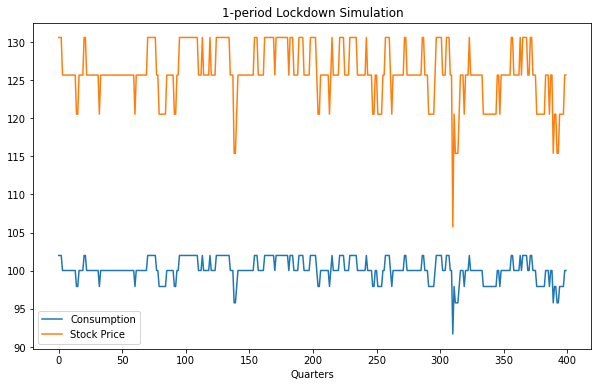

The long-run average consumption is 100.1701554507668
The long-run average stock price for our economy is 126.04800994135316


In [23]:
# setting the seed so we get the same output each time
np.random.seed(20)
n=len(consumption_vector) # number of states
T=400 # time horizon
s0 =np.random.choice(np.arange(0, n), p=long_run[:,0]) # pick a random inital state using π
state=[s0] #history of states
y=[] #GDP array
stock_price = [] # stock price array
for t in range(T):
    s=np.random.choice(np.arange(0, n), p=m_usa[s0,:]) #choose a random state 
    s0=s
    state.append(s)
    y.append(100*consumption_vector[s])
    stock_price.append(prices[s])

long_run_consumption_average = np.mean(y)
long_run_stock_price_avg = np.mean(stock_price)
# plot the outcome
plt.plot(y,label="Consumption")
plt.plot(stock_price,label="Stock Price")
plt.title('1-period Lockdown Simulation')
plt.xlabel('Quarters')
plt.legend()
plt.show()
print('The long-run average consumption is', long_run_consumption_average)
print('The long-run average stock price for our economy is', long_run_stock_price_avg)

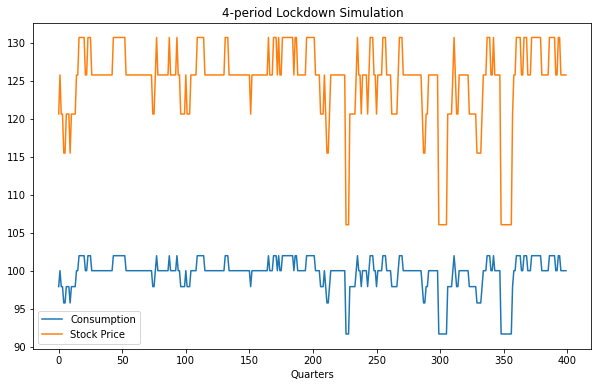

The long-run average consumption is 99.67059140078874
The long-run average stock price for our economy is 124.96329130002825


In [24]:
# again setting the seed so we can reproduce these numbers
np.random.seed(21)
n=len(consumption_vector) # number of states
T=400 # time horizon
s0 =np.random.choice(np.arange(0, n), p=new_long_run[:,0]) # pick a random inital state using π
state=[s0] #history of states
y=[] #GDP array
stock_price = [] # stock price array
for t in range(T):
    s=np.random.choice(np.arange(0, n), p=new_markov[s0,:]) #choose a random state 
    s0=s
    state.append(s)
    y.append(100*consumption_vector[s])
    stock_price.append(new_prices[s])
    
long_run_consumption_average_lockdown = np.mean(y)
long_run_stock_price_avg_lockdown = np.mean(stock_price)
# plot the outcome
plt.plot(y, label = "Consumption")
plt.plot(stock_price, label = "Stock Price")
plt.title('4-period Lockdown Simulation')
plt.xlabel('Quarters')
plt.legend()
plt.show()
print('The long-run average consumption is', long_run_consumption_average_lockdown)
print('The long-run average stock price for our economy is', long_run_stock_price_avg_lockdown)

### Part 12
Calculate the welfare loss from a four-period lockdown as the percentage decrease in long-run average consumption, when comparing a four-period lockdown with a one-period one.  You might want to consider a Rawlsian criterion for welfare loss also; such a criterion would focus on the probability of being in the worst state. Using this article     https://www.pnas.org/content/117/36/22035  explain if a year-long lockdown was worth it.  

In [33]:
((long_run_consumption_average_lockdown - long_run_consumption_average) / (long_run_consumption_average)) * 100

-0.49871545844170684

There is a -0.49% decrease in long-run average consumption when comparing a four-period lockdown with a one-period lockdown. I was personally expecting a much larger change (decrease) in long-run average consumption as an effect of the extended 4-period Covid lockdown state. The percent change does not appear to be catastrophically damaging to the long-term economy, but obviously a 0.49% decrease is not nothing. That welfare loss could be the difference between family businesses staying open, people staying employed etc. Even a slight decrease in welfare has large effects across the world. A four-period lockdown does have major damage to the economy (an 8% drop in consumption is unseen) and would be devastating to those unable to work from home (so most of those who have low-income positions in the service industry), especially with a lack of government support (via stimulus checks, rent and mortgage moratoriums etc). That would directly lead to an increase in poverty, and people struggling to provide even basic necessities like food or shelter. So in that case, a four-period lockdown is likely not worth it (even accounting for the economic value we receive by saving lives, as discussed in the article above).

Not going in to a lockdown also would cause regressive effects though. Those working on the front-lines would be at a higher risk of getting Covid and would have to deal with the adverse health effects that come with Covid. This would lead to a lack of individual productivity, with a potential decrease in life expectancy (and thus reducing long-term economic benefit). In the paper, "Demographic perspectives on the mortality of COVID-19 and other epidemics" by Goldstein and Lee, they calculated the economic damage from deaths due to Covid-19, and that reported that saving 1.75 million lives would be worth 17.5 trillion dollars (based on the economic "worth" of a human life, who is to say what a life is worth). This 1.75 millions deaths comes from an uncontrolled spread of Covid-19, and that may be underrepresenting figures, especially with an increase in deaths coming from lack of ICU space in hospitals (so those who had accidents happen may not get the medical attention they would usually receive due to Covid patients taking up hospital beds). A longer lock-down, until the disease is controlled, in this case could be a smarter way to go. 

**This is an aside:**  
However, knowing how other nations dealt with Covid (longer lockdowns to control the spread, conditional lockdowns based on testing numbers, monthly stimulus checks), it's hard to say the United States specific-approach was a good one. Very little in stimulus payments, and a brief lockdown dependent upon the state's Governor. This just meant Covid stuck around longer, and is why we are still in some state of lockdown desperately relying on the vaccnine distribution to "save the day" all while businesses still can't function at their usual level. Countries like Australia were able to control Covid instead and now their lives are mostly back to normal, while I'm taking my Master's courses online.

**end aside**

We can also consider the Rawlsian criterion for welfare loss as well by looking at the long-term probabilities of being in the "Covid" state from the 1-period and 4-period state. Both of these probabilities were found above. The probability of being in the Covid state in the 1-period scenario is a very small 0.003, so once every 300 years or so. In the 4-period scenario, the probability of being in the Covid state is much larger at 0.013, so about once every 100 years. This is obviously a large change. In the first case, someone could feasibly go their entire life without a "Covid" state. In the second case, the long-run probability of being in a "Covid" state gets much larger, where now a person could almost expect to live through one of these monster economic downturns.

The expected duration of each scenario is also something to consider. In the one period case, the economy is only in the Covid state for one period. Then it's over and the economy is mostly back to normal within a couple of months. The 4-period state has an expected length of 4 quarters (a year in total), this means it could be shorter or longer than a year, but on average you are in this horrible economic state for a year. This could be absolutely devastating. Consider someone fasting, one day every 100 days or so isn't that bad. But fasting for 4 or more days could be killer (and likely will kill you depending on how long this mandatory fast goes).